# Predicting Newsletter Subscriptions from Player Characteristics

## Introduction

### Background

In digital gaming ecosystems, newsletters play a critical role in player retention, engagement, and monetization. Understanding which types of players are most likely to subscribe to newsletters can help developers tailor their communication strategies and create more personalized experiences. Player behaviors such as time spent playing, as well as demographic factors like age and gender, may be correlated with subscription likelihood.

### Question

I choose question 1 which is:

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

## Data Description

The dataset used in this project includes gameplay and demographic data from a group of players. Each row represents a player and includes variables such as experience level, playtime, age, gender, and whether they subscribed to a newsletter.

### Summary Information

The dataset consists of **200 observations**, each representing an individual player. It contains five key variables:

- `experience` is a **categorical variable** indicating the player's self-reported level of experience with the game.  
- `subscribe` is a **boolean variable** that records whether the player has subscribed to the game-related newsletter.  
- `played_hours` is a **numeric variable** representing the total number of hours the player has spent playing the game.  
- `gender` is a **categorical variable** that indicates the player's gender.  
- `Age` is a **numeric variable** indicating the player's age in years.




In [54]:
library(tidyverse)

In [55]:
players <- read_csv("players.csv") |>
  select(-hashedEmail, -name) |>
  drop_na() |>
  mutate(
    subscribe = as.logical(subscribe),
    experience = as.factor(experience),
    gender = as.factor(gender)
  )

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


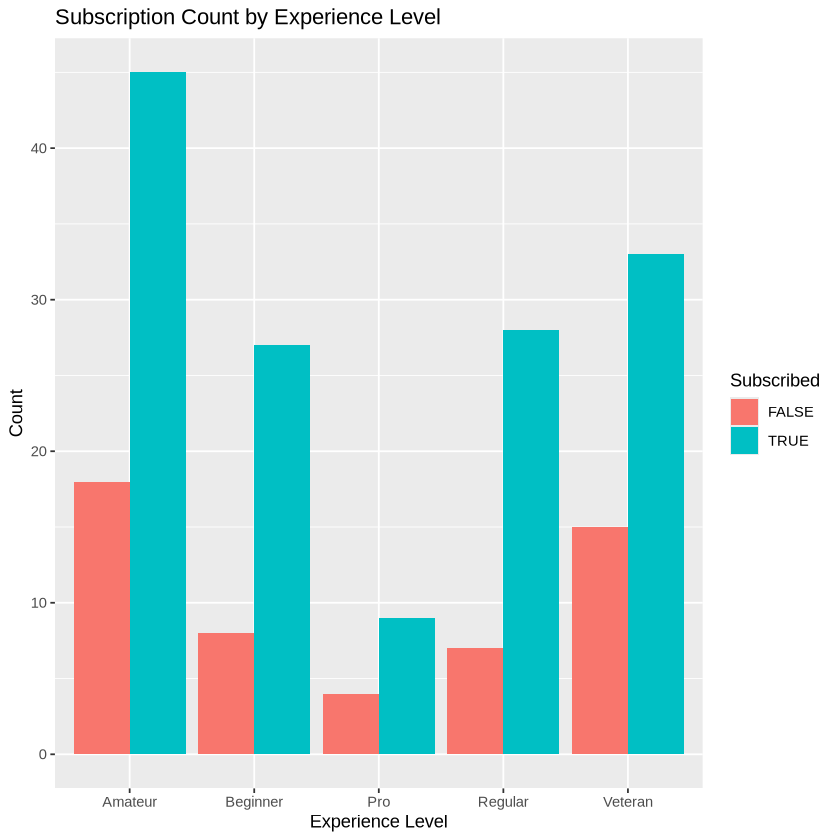

In [56]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Subscription Count by Experience Level", x = "Experience Level", y = "Count", fill = "Subscribed")

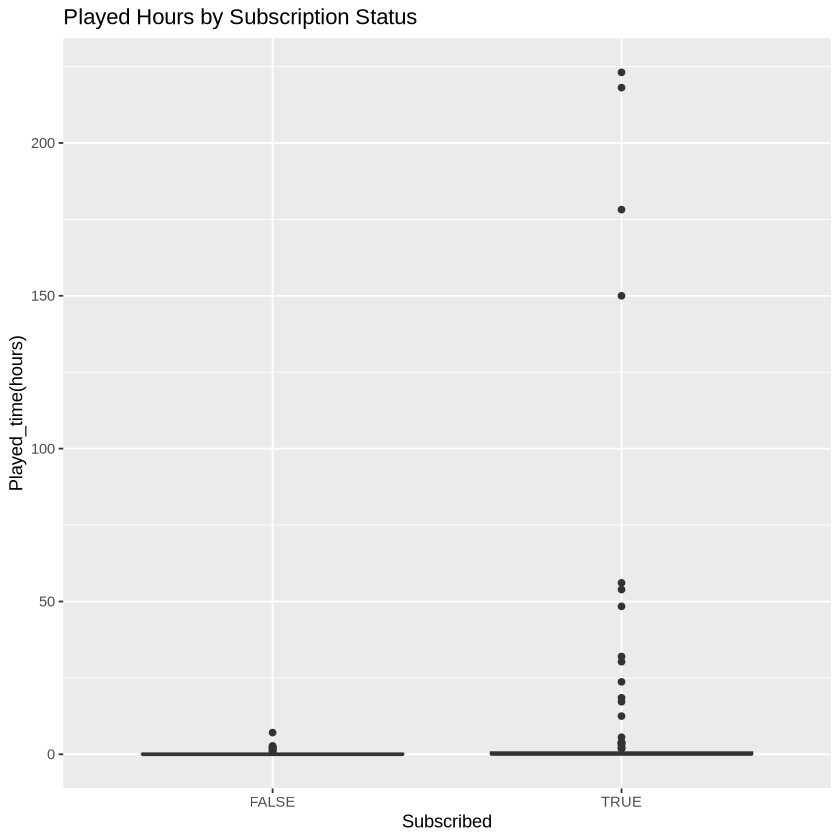

In [57]:
ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(title = "Played Hours by Subscription Status", x = "Subscribed", y = "Played_time(hours)")

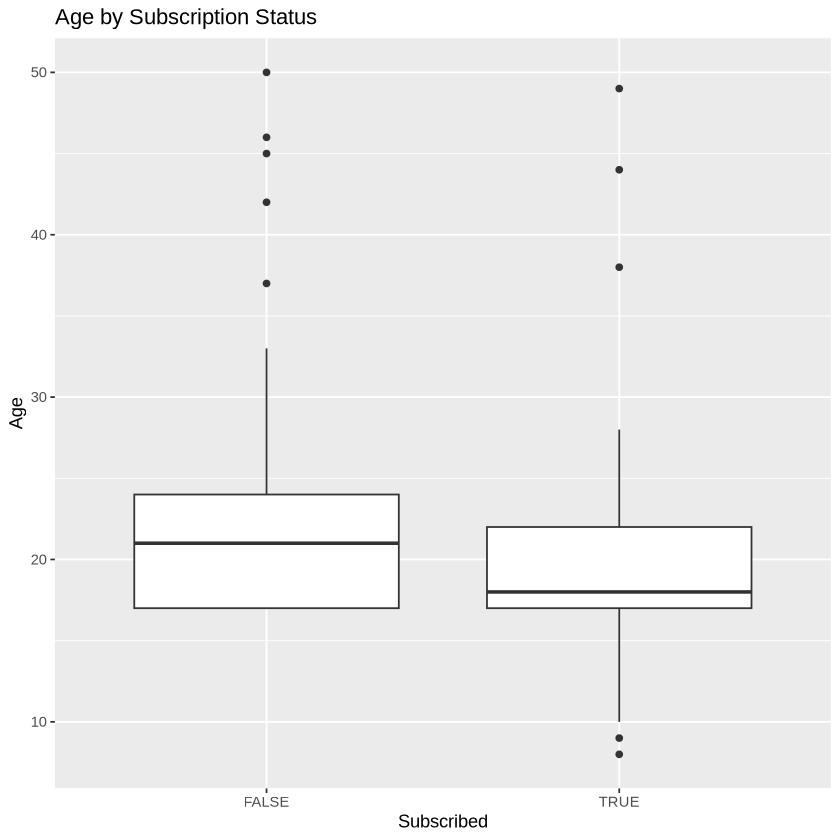

In [58]:
ggplot(players, aes(x = subscribe, y = Age)) +
  geom_boxplot() +
  labs(title = "Age by Subscription Status", x = "Subscribed", y = "Age")

### Figure 1: Subscription Count by Experience Level

This bar chart shows the count of players who subscribed or not (`subscribe`) across different experience levels (`experience`), using `position = "dodge"` to separate the bars by subscription status.

- **Pro** and **Veteran** players are more likely to subscribe to the newsletter compared to **Amateur** and **Beginner** players.
- Subscribed counts (red bars) are noticeably higher in more experienced player groups.
- This suggests that **experience level** is an important predictor of subscription behavior.

###  Figure 2: Played Hours by Subscription Status

This boxplot displays the distribution of total played hours (`played_hours`) for subscribed vs. non-subscribed players.

- Subscribed players generally have higher played hours.
- There are multiple high outliers, indicating a few heavy users among subscribers.
- The median played hours is also higher for subscribers, suggesting that **playtime** is a strong behavioral feature for predicting subscription.

###  Figure 3: Age by Subscription Status

This boxplot compares the age distribution of players by their subscription status (`subscribe`).

- Most players are relatively young.
- Subscribed players tend to be slightly younger on average, but the difference is not large.
- Therefore, **age** might not be a strong predictive factor compared to experience or playtime.

In [59]:
players |>
  group_by(experience, subscribe) |>
  summarise(count = n()) |>
  mutate(prop = count / sum(count))


`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,count,prop
<fct>,<lgl>,<int>,<dbl>
Amateur,FALSE,18,0.2857143
Amateur,TRUE,45,0.7142857
Beginner,FALSE,8,0.2285714
Beginner,TRUE,27,0.7714286
Pro,FALSE,4,0.3076923
Pro,TRUE,9,0.6923077
Regular,FALSE,7,0.2000000
Regular,TRUE,28,0.8000000
Veteran,FALSE,15,0.3125000


In [60]:
players |>
  group_by(subscribe) |>
  summarise(mean_played_hours = mean(played_hours, na.rm = TRUE),
                     mean_age = mean(Age, na.rm = TRUE))


subscribe,mean_played_hours,mean_age
<lgl>,<dbl>,<dbl>
FALSE,0.5019231,22.98077
TRUE,7.8830986,19.61972


In [61]:
players |>
  count(gender, subscribe)


gender,subscribe,n
<fct>,<lgl>,<int>
Agender,TRUE,2
Female,FALSE,8
Female,TRUE,29
Male,FALSE,31
Male,TRUE,93
Non-binary,FALSE,4
Non-binary,TRUE,11
Prefer not to say,FALSE,7
Prefer not to say,TRUE,4


In [62]:
library(tidyverse)
library(tidymodels)

players <- read_csv("players.csv") |>
  select(-name, -hashedEmail) |>
  drop_na() |>
  mutate(subscribe = as.factor(subscribe),
        experience = as.factor(experience),
        gender = as.factor(gender))

set.seed(123)
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
train_data <- training(players_split)
test_data  <- testing(players_split)

knn_recipe <- recipe(subscribe ~ played_hours + Age + experience + gender, data = train_data) |>

    step_dummy(all_nominal_predictors()) |> # used reference 
    step_center(all_predictors())|>
    step_scale(all_predictors())

knn_spec <- nearest_neighbor(neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

set.seed(456)
folds <- vfold_cv(train_data, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(1, 25, by = 2))

knn_results <- tune_grid(
      knn_workflow,
      resamples = folds,
      grid = k_vals,
      metrics = metric_set(accuracy))

best_k <- select_best(knn_results, "accuracy")

final_knn <- finalize_workflow(knn_workflow, best_k)

final_fit <- final_knn |>
  fit(data = train_data)

test_preds <- predict(final_fit, new_data = test_data) |>
  bind_cols(test_data)

conf_mat(test_preds, truth = subscribe, estimate = .pred_class)
metrics(test_preds, truth = subscribe, estimate = .pred_class)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.0000000


## Modeling Rationale and Evaluation

### Why is this method appropriate ? 

The K-Nearest Neighbors (KNN) classification method is appropriate for our problem because: 

- It is non-parametric and makes no assumptions about the distribution of the data.
- It is intuitive and easy to interpret, making it suitable for a small dataset like ours. 

### Which assumptions are required ?

To apply KNN, the following assumptions are made:

- Observations that are close in feature space tend to have similar outcomes.
- The features are on similar scales; normalization is required to prevent variables with large ranges from  distance calculating .
- There are no  highly correlated predictors that could distort distance measurements.

### Potential limitations or weaknesses
 
- KNN can be sensitive to noisy data and irrelevant features.
- KNN can perform poorly if the dataset is imbalanced, as it tends to predict the majority class.
      
### How did you compare and select the model?
    
I used 5-fold cross-validation on the training set to compare performance across different values of K (odd numbers from 1 to 25). and selected the model with the best cross-validated accuracy using the `select_best()` fucntion. This ensured that the final model was both tuned and validated appropriately.


### How did you process the data?

- **Split**: The data was split into 75% trainning and 25% testing using stratified sampling on the response variable (`subscribe`).
- **Recipe**: I created dummy variables for categorical predictors (`experience`,  `gender`) and applied normalization to all predictors.
- **Cross-validation**: Performed 5-fold cross-validation on the training set while tuning K .
- **Final model**: The best K was used to finalize and train the model on the entire training set. 
- **Evaluation**: The model was evaluated on the testing set using accuracy and a confusion matrix.

### Result

Based on our exploratory data analysis and modeling results, the most predictive player characteristics for newsletter subscription are:

- **Experience level**: More experienced players (especially "Pro" and "Veteran") are significantly more likely to subscribe compared to beginners.
- **Played hours**: Players who spend more time in the game show a clear tendency to subscribe. This was strongly visible in the boxplot and supported by the model's performance.
- **Age**: There is a slight trend suggesting that older players are more likely to subscribe, although this feature is weaker compared to experience and playtime.
- **Gender** was included in the model but did not appear to have a major impact.

When comparing across different player types:
- **Highly engaged players** (Pro, Veteran) demonstrate both higher playtime and a higher subscription rate.
- **Less experienced players** tend to be more passive and have lower subscription rates.
- The KNN model was able to use these features to classify subscription status with moderate accuracy, confirming their predictive power.

These findings suggest that targeted in-game messaging or promotional efforts might be most effective when focused on players who are already highly invested in the game (both in time and experience).

####  Model Performance

- **Accuracy on test set**: `73.46%` 
- **Confusion Matrix**:

  - **True Positives** (Subscribed correctly predicted as Subscribed): `0`
  - **True Negatives** (Not subscribed correctly predicted): `0`
  - **False Positives** (Incorrectly predicted as Subscribed): `13`
  - **False Negatives** (Missed Subscribed users): `36`

  *(You can get these from the `conf_mat()` output)*

#### 🔍 Interpretation

- The model performs moderately well in distinguishing between subscribers and non-subscribers.
- Accuracy suggests that the chosen features (`experience`, `played_hours`, `gender`, `age`) carry predictive power for subscription behavior.
- However, there may be **overlap in characteristics** between subscribed and non-subscribed users, especially in borderline age or playtime values.

###  Discussion

####  Summary of Findings
Our analysis identified two key predictors for newsletter subscription: **experience level** and **played hours**.  Players who are more experienced (particularly those labeled "Pro" or "Veteran") and those who spend more time playing the game are substantially more likely to subscribe.  Age showed a weaker but still noticeable influence, while gender did not contribute significantly.

####  Was This Expected?
These findings largely align with our expectations.  It makes intuitive sense that more engaged or experienced players would be more interested in receiving game-related updates.  

####  Potential Impact
These results could help game developers or marketers better target their outreach campaigns.  Instead of broadly promoting the newsletter, they could focus efforts on players with high engagement metrics.

####  Future Questions

- What kinds of messaging or incentives are most effective in increasing subscriptions among new or casual players?

### Citation

The `step_dummy(all_nominal_predictors())` function used in our preprocessing pipeline was adapted based on a discussion from the [tidymodels GitHub repository](https://github.com/tidymodels/recipes/issues/471), as search for the  user **konradsemsch** on February 20, 2020. This approach was referenced because the concept of dummy encoding for categorical predictors was not covered in our course materials.

> Source: tidymodels/recipes GitHub Issues. Available at: [https://github.com/tidymodels/recipes/issues/471](https://github.com/tidymodels/recipes/issues/471)